In [26]:
import os
import json
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: put this notebook in the same directory as the logs
# Load logs from JSON into list of dictionaries
folderPath = os.path.pardir + '/logs 170928'
files = [os.path.join(folderPath, f) for f in next(os.walk(folderPath))[2]]
print files


['../logs 170928/.DS_Store', '../logs 170928/0', '../logs 170928/10', '../logs 170928/12', '../logs 170928/13', '../logs 170928/14', '../logs 170928/15', '../logs 170928/17', '../logs 170928/18', '../logs 170928/19', '../logs 170928/2', '../logs 170928/20', '../logs 170928/21', '../logs 170928/22', '../logs 170928/3', '../logs 170928/4', '../logs 170928/5', '../logs 170928/6', '../logs 170928/8', '../logs 170928/9']


In [27]:
# Function to extract coorinates as 2 x number of steps array
def get_coords(mouse):
    # Empty array
    coords = np.zeros((2, len(mouse)))

    # Load coordinates into array 
    for i, t in enumerate(mouse):
        # Note that becuase web axis are left-down, we invert the y
        coords[0,i] = t['x']
        coords[1,i] = -t['y']

    # Subtract start from all plints to center at 0,0
    x_start, y_start = coords[0,0], coords[1,0]
    coords -= np.array([[x_start],[y_start]])
    
    # Return our coordinate array
    return coords

In [28]:
# Function to rotate coordinates so start and end are on x-axis
def rot_coords(coords):

    # Get start and end for angle
    x_start, y_start = coords[0,0], coords[1,0]
    x_end, y_end = coords[0,-1], coords[1,-1]

    # Some trig to make rotation matrix... SOHCAHTOA! SOHCAHTOA! SOHCAHTOA!
    r = -math.atan2((y_end-y_start),(x_end-x_start))
    R = np.array([[math.cos(r), -math.sin(r)],[math.sin(r), math.cos(r)]])
    
    # Return the rotated coordiantes and the maximnum absolute y value
    rotated = np.matmul(R, coords)
    max_y = np.abs(rotated[1,:]).max()
    
    return rotated, max_y

In [29]:
# Empty array for all log files
tests = []

# Load in logs
for f in files:
    if os.path.basename(f) not in ['.DS_Store', '.gitignore','mouse_movement.ipynb']:
        with open(f, 'r') as f:
            data = json.load(f)
            tests.append(data)

In [30]:
# Empty arrays to construct our dataframe (or numpy array)
name = []
device = []
image = []
flag = []
action = []
mouse = []
owl = []
all_coords = []

# Loop over every test in logs
for test in tests:
    # Loop over every iamge in logs 
    for img in test['experiment']:
        if img['dataType'] == "trial":
            
            # Load relevant data into array
            name.append(test['name'])
            device.append(test['device'])
            flag.append(img['flag'])
            
            # For images, label sd actual o fake
            if 'not' in img['trialImage']:
                image.append(False)
            else:
                image.append(True)
            
            # For 'owl' or warmup category
            if 'owl' in img['trialImage']:
                owl.append(True)
            else:
                owl.append(False)
            
            # For action
            if img['action'] == 'optionA':
                action.append(True)
            else:
                action.append(False)
                
            # Get maximum deviation in rotated coordinated 
            coords = get_coords(img['mouse'])
            coords2, max_y = rot_coords(coords)
            
            all_coords.append(coords2)
            mouse.append(max_y)

AttributeError: 'module' object has no attribute 'matmul'

In [105]:
# Function to classify test condition
def classify_condition(df):
    if df.image and df.flag:
        return 'imgT_aiT'
    elif df.image and not df.flag:
        return  'imgT_aiF'
    elif not df.image and df.flag:
        return  'imgF_aiT'
    elif not df.image and not df.flag:
        return  'imgF_aiF'

In [106]:
# Construct a Pandas dataframe in case we want to do maths
df = pd.DataFrame({'name':name, 'image':image, 'flag':flag, 'action':action, 'mouse':mouse, 'device':device, 'owl':owl})
#df.image = df.image.astype(int)
#df.flag = df.flag.astype(int)
#df.owl = df.owl.astype(int)
#df.action = df.action.astype(int)
df.head(n=20)

,action,device,flag,image,mouse,name,owl
0,False,mouse,None,True,17.760061,Brian,True
1,False,mouse,None,True,28.909750,Brian,True
2,False,mouse,None,True,13.953668,Brian,True
3,False,mouse,None,True,20.967816,Brian,True
4,False,mouse,None,False,16.950286,Brian,True
5,False,mouse,None,False,12.811772,Brian,True
6,False,mouse,None,True,6.796884,Brian,True
7,False,mouse,None,True,6.174807,Brian,True
8,False,mouse,None,True,17.082513,Brian,True
9,False,mouse,None,True,8.682874,Brian,True


In [107]:
df['cond'] = df.apply(lambda x: classify_condition(x), axis = 1)
df.head()

,action,device,flag,image,mouse,name,owl,cond
0,False,mouse,None,True,17.760061,Brian,True,imgT_aiF
1,False,mouse,None,True,28.909750,Brian,True,imgT_aiF
2,False,mouse,None,True,13.953668,Brian,True,imgT_aiF
3,False,mouse,None,True,20.967816,Brian,True,imgT_aiF
4,False,mouse,None,False,16.950286,Brian,True,imgF_aiF


In [108]:
df_nowl = df.loc[df.owl == False]
df_nowl.head()

,action,device,flag,image,mouse,name,owl,cond
10,True,mouse,True,False,11.712436,Brian,False,imgF_aiT
11,True,mouse,True,False,29.125670,Brian,False,imgF_aiT
12,True,mouse,False,True,47.579909,Brian,False,imgT_aiF
13,True,mouse,False,True,5.301998,Brian,False,imgT_aiF
14,True,mouse,False,True,27.528139,Brian,False,imgT_aiF


In [110]:
split = df_nowl.groupby(['name', 'cond'])['mouse'].mean()
split = split.unstack()
split.head()

cond,imgF_aiF,imgF_aiT,imgT_aiF,imgT_aiT
name,,,,
Brian,32.690520,18.080303,19.715162,15.820034
steve,13.411919,18.083864,14.975052,25.027980


In [111]:
# To CSV
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M_")
df.to_csv(timestamp + 'stacked.csv')
split.to_csv(timestamp + 'split.csv')

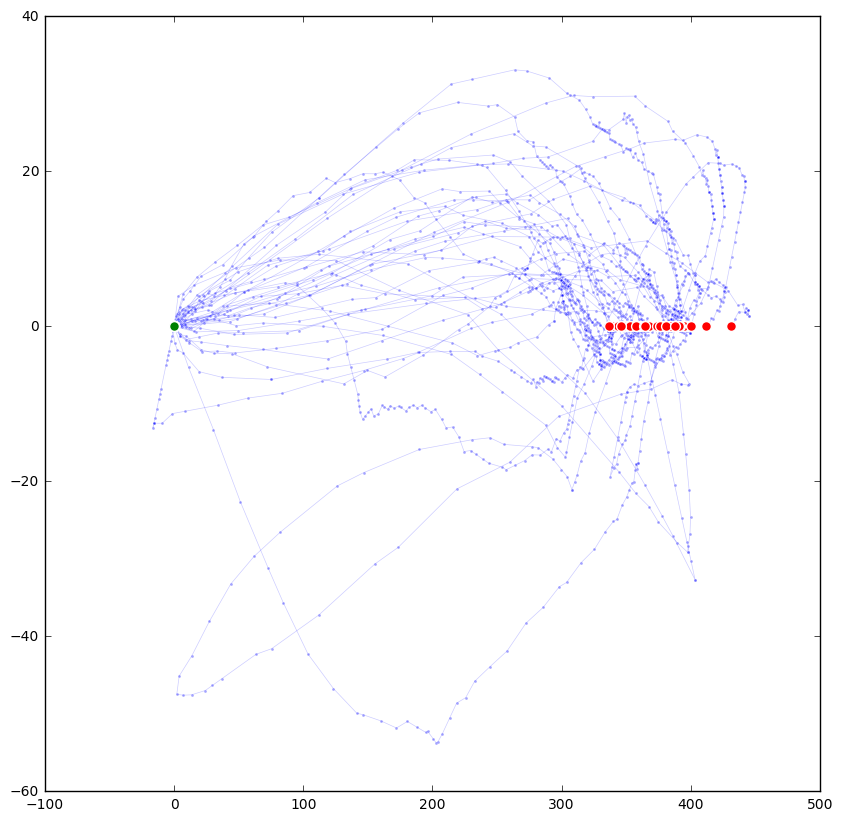

In [12]:
# Plot to check for first user
coords_user = all_coords[:40]

plt.figure(figsize=(10,10))

for coords in coords_user:
    plt.plot(coords[0,:], coords[1,:] , lw = .5, c = 'blue', alpha = 0.2, ms=2, mec='white', marker='o', zorder=1)
    plt.scatter(coords[0,0], coords[1,0], c='green', s=50, lw = 1, edgecolors='white', label='START', zorder=10)
    plt.scatter(coords[0,-1], coords[1,-1], c='red', s=50, lw = 1, edgecolors='white', label='END', zorder=10)

plt.show()
